In [1]:
# %reload_ext autoreload
# %autoreload 1
# from classes.helper_functions import HelperFuncs

# h = HelperFuncs()

TypeError: exponential_decay() missing 1 required positional argument: 'self'

,Text,sentiment
0,What other steps do you recommend in order to ...,0
1,In when he went to Oxford his great ambition w...,0
2,This story first appeared on Chip Chick,0
3,More than percent of the drivers surveyed said...,0
4,Under the Affordable Care Act everyone is requ...,0
5,Because of me it became controversial and felt...,0
6,The reasoning behind the complaint Celli expla...,1
7,With stocks everyone knows that you re suppose...,0
8,Millennials the so called spoiled generation b...,0
9,Leave comment below or email us at pacfcya tre...,0


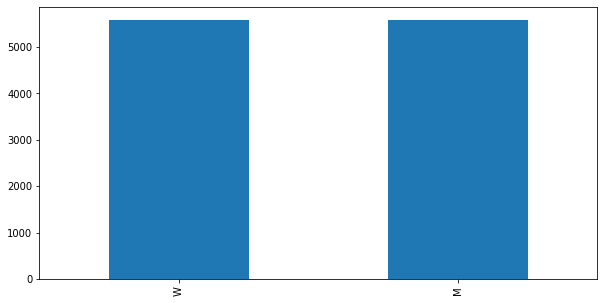

In [12]:
import pandas as pd

df = pd.read_json('../datasets/8_dataset_simple.json')
df = df[df.Text != " "]

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['sentiment'] = df.Gender.apply(lambda x: 0 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df = df.sample(frac=1).reset_index(drop=True)

split = round(len(df)*0.75)
train_data = df[:split]
test_data = df[split:]

train_data.head(10)

In [13]:
import os
import time
import tensorflow as tf
from keras import callbacks

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

model_name = 'entire_sentences'
model_variant = '1_dropout'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

In [14]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import tensorflow as tf
import numpy as np

vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['Text'])

train_seqs = tokenizer.texts_to_sequences(train_data['Text'])
X_train = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)
test_seqs = tokenizer.texts_to_sequences(test_data['Text'])
X_test = pad_sequences(test_seqs, maxlen=max_length)

y_train = np.array(train_data['sentiment'])
y_test = np.array(test_data['sentiment'])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3, noise_shape=None, seed=None),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# model_name = 'entire_sentences'
# model_variant = 'base'
# tensorboard_cb = callbacks.TensorBoard(h.get_run_logdir('logged_models/' + model_name + '/' + model_variant))

# history = model.fit(X_train, y_train, epochs=20, callbacks =[h.earlystopping, h.lr_scheduler, tensorboard_cb], validation_split=0.2)
history = model.fit(X_train, y_train, epochs=50, callbacks =my_callbacks, validation_split=0.2)
model.save('classifiers/' + model_name + '/' + model_variant + '.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           640000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 640,289
Trainable params: 640,289
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
210/210 [==============================] - 2s 7ms/step - loss: 0.6672 - accuracy: 0.5599 - val_loss: 0.

<Figure size 432x288 with 0 Axes>

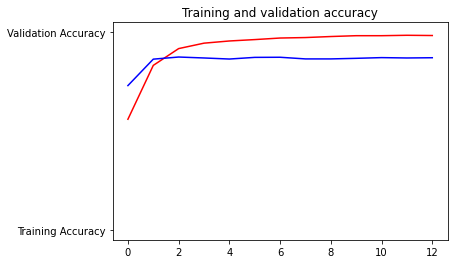

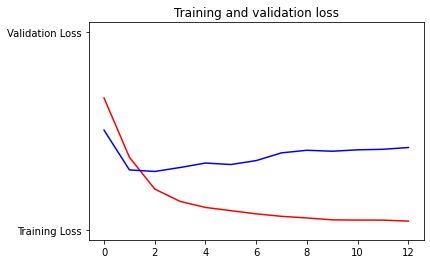

<Figure size 432x288 with 0 Axes>

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [17]:
y_pred = model.predict(X_test)
y_pred_binary = []
for x in y_pred:
    y_pred_binary.append(0 if x < 0.5 else 1)

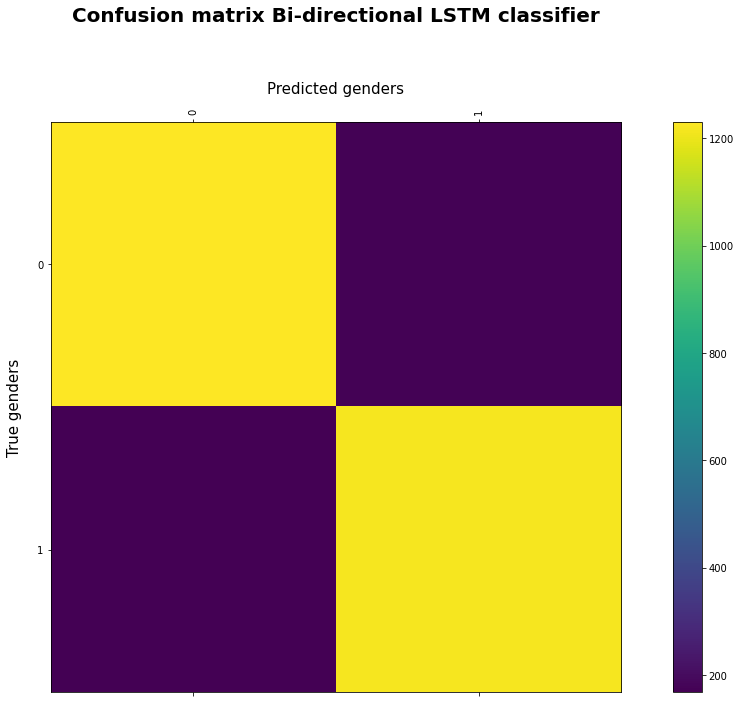

array([[1231,  174],
       [ 168, 1218]], dtype=int64)

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted genders', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True genders', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(2), [0,1], rotation=90)
plt.yticks(range(2), [0,1])

newpath = r'test_results/' + model_name + '/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
plt.savefig('test_results/' + model_name + '/' + model_variant + '_cm.png')


plt.show()
cm

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_18392/2123976842.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.88,0.88,0.88,1405.0
1,W,0.88,0.88,0.88,1386.0


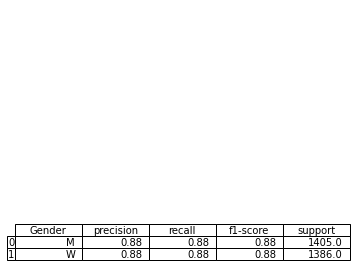

In [20]:
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'W']

report = classification_report(y_test, y_pred_binary, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)

# Borrowed from: https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png
from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
table(ax, df_perf_2)  # where df is your data frame
plt.savefig('test_results/' + model_name + '/' + model_variant + '_metrics.png')

df_perf_2